In [1]:
from matplotlib import pyplot as plt
import tensorflow as tf
import numpy as np

In [2]:
class Layer:
    """
    Define the structure of every layer.
    
    Paras:
      input_dim: size of input dataset
      output_dim: number of neurons
      activation: activation function, default: None(i.e. without activation function)
      
    Properties:
      activation: activation function
      W, b: weights of the layer
      weights: a list that contains W and b
      
    You can just call a layer to execute the progress called "forward pass"
    """
    def __init__(self, input_dim, output_dim, activation=None):
        self.activation = activation
        
        # initial weights
        std = np.sqrt(2 / (input_dim + output_dim))
        self.W = tf.Variable(initial_value=tf.random.normal(shape=(input_dim, output_dim), stddev=std))
        self.b = tf.Variable(initial_value=tf.zeros(shape=(output_dim, )))
        
    def __call__(self, inputs):
        # forward pass
        if self.activation:
            return self.activation(tf.matmul(inputs, self.W) + self.b)
        else:
            # If the layer don't have an activation, go linear combination directly
            return tf.matmul(inputs, self.W) + self.b
        
    @property
    def weights(self):
        # define "weight" property
        return [self.W, self.b]
    
class Model:
    """
    Define the model
    
    Paras:
      layers: a list of Layer
      xmin, xmax: the range of the PDE
      
    Properties:
      layers: a list of Layer
      xmin, xmax: the range of the PDE
      weights: a list that contains weights of each layer
      
    You can call the model to calculate the result based on given dataset
    """
    def __init__(self, layers, xmin, xmax):
        self.layers = layers
        self.xmin = xmin
        self.xmax = xmax
        
    def __call__(self, training_set):
        x = training_set
        x = 2.0 * (x - self.xmin) / (self.xmax - self.xmin) - 1.0
        for layer in self.layers:
            # update inputs
            x = layer(x)
        return x
    
    @property
    def weights(self):
        # 将所有layer的参数整合在一起
        weights = []
        for layer in self.layers:
            weights += layer.weights
        return weights

In [3]:
def train_step(model, optimizer, lambda_lst, X_train, u_train, w1=1, w2=1):
    """
    One training step using SGD. Return loss score after SGD.
    
    Params:
      model: an NN/DNN model
      optimizer: a Keras optimizer, to implement SGD
      lambda_lst: a list of params of the PDE
      X_train: training set for x
      u_train: training set for u
      w1, w2: weights for loss of PDE and loss of data
    """
    
    # In an inverse problem, we have to train parameters in the pde
    weights = model.weights + lambda_lst
    
    # Calculate loss
    with tf.GradientTape() as utter_tape:
        with tf.GradientTape() as outer_tape:
            with tf.GradientTape() as inner_tape:
                x = X_train # alias for convenience
                u = model(x)
            u_x = inner_tape.gradient(u, x)
        u_xx = outer_tape.gradient(u_x, x)
        
        f = np.pi**2 * np.sin(np.pi * x)
        
        # loss of the pde
        loss_f = tf.reduce_mean(tf.square(-lambda_lst[0] * u_xx - f))
        # loss of the data
        loss_u = tf.reduce_mean(tf.square(u - u_train))
        # total loss
        loss = w1 * loss_f + w2 * loss_u
    
    optimizer.minimize(loss, weights, tape=utter_tape)
    return lambda_lst, loss

def train_model(model, lambda_lst, X_train, u_train, w1=1, w2=1, epochs=1000, learning_rate=0.0008, warning=False):
    """
    Train NN/DNN model.
    
    Params:
      model: an NN/DNN model
      lambda_lst: a list of params of the PDE
      X_train: training set for x
      u_train: training set for u
      w1, w2: weights for loss of PDE and loss of data
      epochs: times of training
      learning_rate: learning rate
      warning: whether to show loss score of each epoch and pde parameters in each epoch

    Return values:
      loss_history: a list of loss scores in the training progress
      lambda_history: a list of lambda values(i.e params of the PDE) in each training step
    """
    
    loss_history = []
    lambda_history = []
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    for epoch in range(epochs):
        lambda_lst, loss = train_step(model, optimizer, lambda_lst, X_train, u_train, w1, w2)
        loss_history.append(loss)
        lambda_history.append([tf.Variable(_lambda) for _lambda in lambda_lst])
        if warning:
            print(f'epoch: {epoch + 1}, loss: {loss:.5f}')
            for i in range(len(lambda_lst)):
                print(f'lambda{i+1}: {lambda_lst[i].numpy()[0]:.5f}')
            print()
            
    return loss_history, lambda_history

# Problem setup

PDE:
$$\left\{\begin{array}{l}
-\lambda u^{''}(x) = f(x) \quad x \in (-1, 1) \\
u(-1) = u(1) = 0
\end{array}\right.$$

where $f(x) = \pi^2 \sin(\pi x)$.

Exact solution(for generating training set): $u(x) = sin(\pi x)$.

We're going to train a DNN to approximate $\lambda$. (The exact result is $\lambda = 1$)

In [4]:
def u_exact(x):
    """
    The exact solution of PDE.
    """
    return tf.sin(np.pi * x)

In [5]:
# training set
# here I use the exact solution to generate training set

xmin = -1
xmax = 1
point_counts = 2000

x = xmin + (xmax - xmin) * np.random.rand(point_counts, 1)
X_train = tf.Variable(initial_value=x, dtype='float32')
# exact `u` value of training set
u_train = u_exact(X_train)

X_min = tf.Variable(initial_value=[[xmin]], dtype="float32")
X_max = tf.Variable(initial_value=[[xmax]], dtype="float32")

In [6]:
# Initialize parameters in PDE
lambda1 = tf.Variable(initial_value=[0], dtype="float32")
lambda_lst = [lambda1, ]
initial_lambda_lst = [tf.Variable(_lambda) for _lambda in lambda_lst] # deep copy, just for comparing the original value and the results

# if you have multiple parameters in PDE
# make sure create them as 0D tensor
# then append them to the lambda_lst

model = Model([
    Layer(input_dim=1, output_dim=40, activation=tf.nn.tanh),
    Layer(input_dim=40, output_dim=40, activation=tf.nn.tanh),
    Layer(input_dim=40, output_dim=40, activation=tf.nn.tanh),
    Layer(input_dim=40, output_dim=1, activation=None)
], X_min, X_max)

In [7]:
epochs = 20000
learning_rate = 8e-4
loss_history, lambda_history = train_model(model, lambda_lst, X_train, u_train,
                           w1=1, w2=1, epochs=epochs, learning_rate=learning_rate, warning=False)

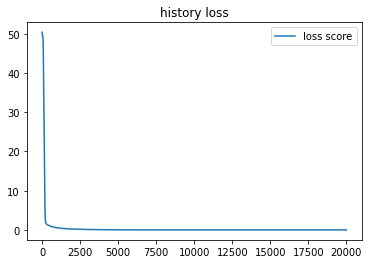

Final loss score: 1.5383095160359517e-05


In [11]:
plt.plot(np.array(range(epochs)) + 1, loss_history, label='loss score')
plt.title('history loss')
plt.legend()
plt.show()

print(f'Final loss score: {loss_history[-1]}')

lambda0
value before training: 0.0; value after training: 0.999539


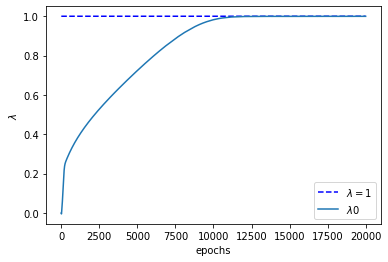

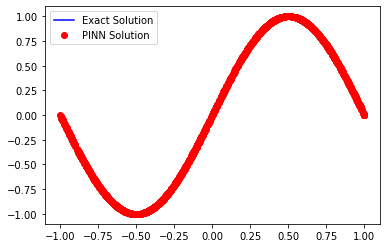

In [9]:
# plot params results and history
for i in range(len(lambda_lst)):
    final_result = lambda_history[-1]
    print(f"lambda{i}")
    print(f"value before training: {initial_lambda_lst[i].numpy()[0]}; value after training: {final_result[i].numpy()[0]:5f}")

plt.figure()
epoch_array = np.array([epoch + 1 for epoch in range(epochs)])
plt.plot(epoch_array, np.ones_like(epoch_array), 'b--', label='$\lambda=1$')

for i in range(len(lambda_lst)):
  lambda_i_history = np.array(lambda_history)[:, i]
  lambda_i_history = lambda_i_history[:, 0] # (shape) change (epochs, 1) to (epochs,)
  plt.plot(epoch_array, lambda_i_history, label=f'$\lambda${i}')

plt.xlabel('epochs')
plt.ylabel('$\lambda$')
plt.legend()
plt.savefig('lambda_progress.png')
plt.show()
plt.close()

# plot model results

u_pred = model(X_train)

plt.figure()
plt.plot(np.linspace(-1, 1, 201), u_exact(np.linspace(-1, 1, 201)), 'b-', label='Exact Solution')
plt.plot(X_train, u_pred, 'ro', label='PINN Solution')
plt.xlim([-1.1, 1.1])
plt.ylim([-1.1, 1.1])
plt.legend()
plt.savefig('model_results.png')
plt.show()
plt.close()